In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime as dt

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%matplotlib inline

# Data LOSS

In [2]:
fld = pd.read_csv('./data/output/fld.csv', sep=';')
fld.source = fld.source.fillna('LOSS')

In [3]:
fld['date'] = pd.to_datetime(fld.dep).dt.floor('D')
st = fld.groupby('date').source.value_counts()

In [4]:
st = st.unstack(fill_value=0)

In [5]:
st['TOTAL'] = st.ACARS + st.SURVEY + st.FDM + st.LOSS
st.to_csv('./data/output/stats.csv', sep=';', decimal=',')
st.tail(7)

source      ACARS  FDM  LOSS  SURVEY  TOTAL
date                                       
2020-06-04     39    0    11      15     65
2020-06-05     53    0     4      24     81
2020-06-06     31    0    10      15     56
2020-06-07     31    0     6       8     45
2020-06-08     47    0    16      21     84
2020-06-09     33    0     8      15     56
2020-06-10     18    0    11       6     35

In [6]:
st_prop = pd.DataFrame()

for c in st.columns:
    if c!= 'TOTAL':
        st_prop[c] = st[c]/st['TOTAL']

In [7]:
st_prop = st_prop[['ACARS', 'SURVEY', 'FDM' ,'LOSS']]
st_prop = st_prop.head(-1)

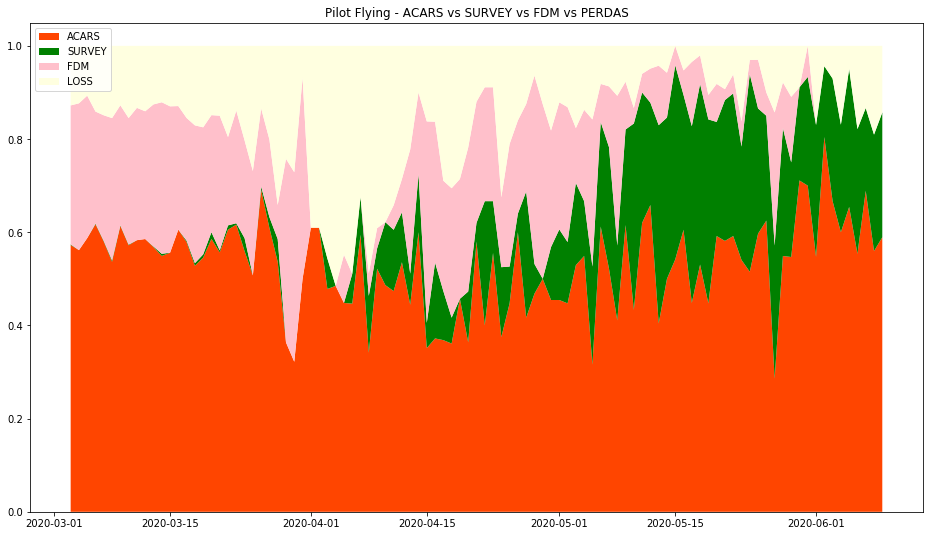

In [8]:
fig, ax = plt.subplots(figsize=[16,9])
ax.stackplot(
    st_prop.index, 
    [st_prop[c] for c in st_prop.columns], 
    labels=st_prop.columns,
    colors=['orangered', 'green', 'pink', 'lightyellow']
)


plt.title('Pilot Flying - ACARS vs SURVEY vs FDM vs PERDAS')
plt.legend(loc='upper left')


plt.savefig('./data/output/charts/data_loss.png')
plt.show()


In [9]:
source_by_acft = fld.groupby('acft').source.value_counts()

In [10]:
source_by_acft = source_by_acft.unstack(fill_value=0)

In [11]:
source_by_acft['TOTAL'] = source_by_acft.sum(axis=1)

In [12]:
source_by_acft['SCORE'] = source_by_acft['ACARS']/source_by_acft['TOTAL']

In [13]:
source_by_acft = source_by_acft.sort_values('SCORE')
source_by_acft.to_csv('./data/output/acft_has_acars.csv', sep=';')

In [14]:
st_prop

ACARS    SURVEY       FDM      LOSS
date                                              
2020-03-03  0.572570  0.001332  0.298269  0.127830
2020-03-04  0.561644  0.000000  0.315068  0.123288
2020-03-05  0.587450  0.000000  0.305741  0.106809
2020-03-06  0.617076  0.001294  0.240621  0.141009
2020-03-07  0.579732  0.001490  0.269747  0.149031
...              ...       ...       ...       ...
2020-06-05  0.654321  0.296296  0.000000  0.049383
2020-06-06  0.553571  0.267857  0.000000  0.178571
2020-06-07  0.688889  0.177778  0.000000  0.133333
2020-06-08  0.559524  0.250000  0.000000  0.190476
2020-06-09  0.589286  0.267857  0.000000  0.142857

[99 rows x 4 columns]

# Workforce LOSS

In [15]:
exp_dates = pd.read_csv('./data/output/rex_complete.csv', sep=';')
exp_dates.exp_date = pd.to_datetime(exp_dates.exp_date)
exp_dates['is_expired'] = exp_dates.exp_date.isna() | (exp_dates.exp_date < dt.now())

In [16]:
__rank = ['CMT', 'COP']
__base = ['GRU', 'CGH', 'GIG', 'SDU', 'FOR', 'POA', 'BSB']

In [17]:
def filter_exp_dates(exp_dates, rank, base):
    return exp_dates[(exp_dates.funcao.isin(rank)) & (exp_dates.base.isin(base))]

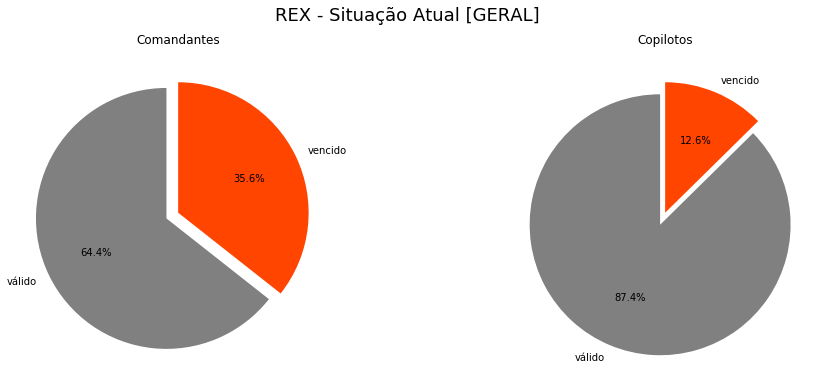

In [18]:
# Current status
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
plt.suptitle('REX - Situação Atual [GERAL]', fontsize=18)

# cmts
df = filter_exp_dates(exp_dates, ['CMT'], __base)
ax[0].pie(
    df.is_expired.value_counts(sort=False),
    explode = (0.1, 0),
    colors = ('grey', 'orangered'),
    autopct='%1.1f%%',
    labels = ('válido', 'vencido'),
    startangle = 90
)
ax[0].set_title('Comandantes')

# cops
df = filter_exp_dates(exp_dates, ['COP'], __base)
ax[1].pie(
    df.is_expired.value_counts(sort=False),
    explode = (0.1, 0),
    colors = ('grey', 'orangered'),
    autopct='%1.1f%%',
    labels = ('válido', 'vencido'),
    startangle = 90
)
ax[1].set_title('Copilotos')

plt.savefig('./data/output/charts/validade_geral.png')
plt.show()

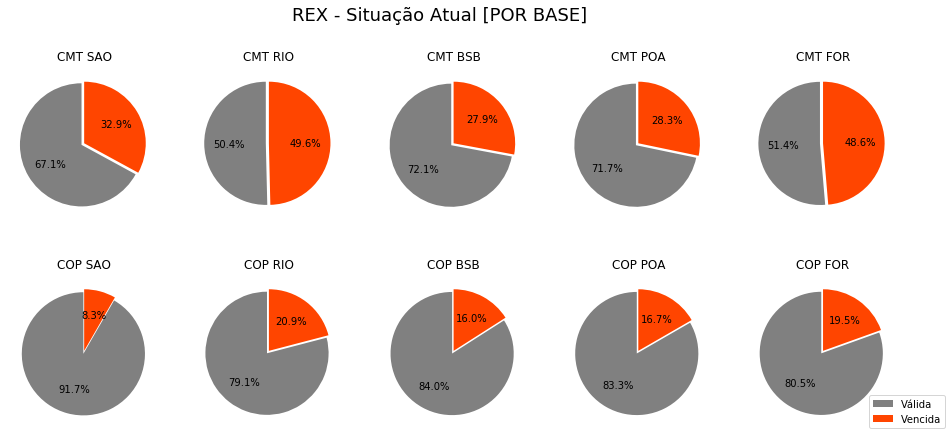

In [19]:
# Current status
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(16,7))
plt.suptitle('REX - Situação Atual [POR BASE]', fontsize=18)

base_names = ['SAO', 'RIO', 'BSB', 'POA', 'FOR']
base_airports= [['CGH', 'GRU'], ['SDU', 'GIG'], ['BSB'], ['POA'], ['FOR']]

for ix, base in enumerate(base_names):
    df = filter_exp_dates(exp_dates, ['CMT'], base_airports[ix])
    ax[0, ix].pie(
        df.is_expired.value_counts(sort=False),
        explode = (0.05, 0),
        colors = ('grey', 'orangered'),
        autopct='%1.1f%%',
        startangle = 90
    )
    ax[0, ix].set_title(f'CMT {base}')
    
    df = filter_exp_dates(exp_dates, ['COP'], base_airports[ix])
    ax[1, ix].pie(
        df.is_expired.value_counts(sort=False),
        explode = (0.05, 0),
        colors = ('grey', 'orangered'),
        autopct='%1.1f%%',
        startangle = 90
    )
    ax[1, ix].set_title(f'COP {base}') 

plt.legend(
    ('Válida', "Vencida"),
    loc=(.8,0)
)
   
plt.savefig('./data/output/charts/validade_por_base.png')
plt.show()

In [20]:
dates = np.arange(np.datetime64('today'), np.datetime64('today') + np.timedelta64(90, 'D'))
x = exp_dates[['cif', 'funcao', 'base', 'exp_date']]
x = x[~x.exp_date.isna()]

In [21]:
for d in dates:
    x[str(d)] = x.exp_date > d

In [22]:
def agg_valid_count(x, ranks, bases):
    df = x[(x.funcao.isin(ranks)) & (x.base.isin(bases))]
    cols = [c for c in df.columns if c.startswith('202')] 
    df = df[cols].sum(axis=0)
    df.index = pd.to_datetime(df.index)
    return df

In [23]:
# projection
base_names = ['TODAS', 'SAO', 'RIO', 'BSB', 'POA', 'FOR']
base_airports= [['CGH', 'GRU', 'SDU', 'GIG', 'BSB', 'POA', 'FOR'],
                ['CGH', 'GRU'],
                ['SDU', 'GIG'],
                ['BSB'],
                ['POA'],
                ['FOR']]


fig, ax = plt.subplots(ncols=1, nrows=6, figsize=(16,18), sharex=True)
plt.suptitle('Quantidade de pilotos com REX válido', fontsize=16, y=.92)
for ix, base in enumerate(base_names):
    df = agg_valid_count(x, ['CMT'], base_airports[ix])
    ax[ix].plot(df,color='orangered')
    df = agg_valid_count(x, ['COP'], base_airports[ix])
    ax[ix].plot(df, color='grey')
    ax[ix].legend(['CMT', 'COP'])
    
    ax[ix].xaxis.set_major_locator(mdates.MonthLocator())
    ax[ix].xaxis.set_minor_locator(mdates.DayLocator())
    
    ax[ix].set_title(f'Base - {base}')
    ax[ix].grid(which='major', axis='x', linestyle='--')
    
    # chart backgroud labels
    l = pd.DataFrame({'date': pd.to_datetime(dates)}, index=dates)
    l['label'] = l.date.dt.strftime('%b %y').str.upper()
    l = l.groupby('label').date.agg(['count', 'first'])
    l['show'] = l['count'] > 14
    l['position'] = l['first'] + l['count'].astype('timedelta64[D]')/2
    l = l.reset_index()
    
    
    y = ax[ix].get_ylim()[1]/2
    for _, (label, _, _, show, position) in l.iterrows():
        if show:
            ax[ix].text(position, y, label, alpha=.2, ha='center', fontsize=20)
plt.subplots_adjust()
plt.savefig('./data/output/charts/projection.png')
plt.show()